In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle


def import_pkl(file_path):
    # Specify the path to the pickle file

    # Load the pickle file
    try:
        with open(file_path, 'rb') as f:
            loaded_data = pickle.load(f)

        print("Pickle file loaded successfully.")
        # You can now work with 'loaded_data'

        return loaded_data

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")


In [ ]:
import numpy as np


def maik_pairs(data_signature:list[list, list]):
    pairs = []
    labels = []

    def preprocess(img):
        return np.expand_dims(img, axis=-1)

    def append(img1, img2, value):
        pairs.append([img1, img2])
        labels.append(value)

    total_samples = len(data_signature)

    for i in range(total_samples):

        print(f"\rMuestra: [{i+1}/{total_samples}]", end="")

        forge, genuine = data_signature[i]

        for j in range(len(forge)):
            forge[j] = preprocess(forge[j])

        for j in range(len(genuine)):
            genuine[j] = preprocess(genuine[j])

        # 1. Comparaciones genuino vs genuino (misma clase → label 0)
        for i in range(len(genuine)):
            for j in range(i + 1, len(genuine)):
                append(genuine[i], genuine[j], "0")

        # 2. Comparaciones genuino vs forge (clases distintas → label 1)
        for img_genuine in genuine:
            for img_forge in forge:
                append(img_genuine, img_forge, "1")

    print()
    return np.array(pairs), np.array(labels)

In [ ]:
train_pairs, train_labels = maik_pairs(
    import_pkl('/content/drive/MyDrive/dataset_signature/train_image_matrices.pkl')
)

Pickle file loaded successfully.
Muestra: [150/150]


In [ ]:
test_pairs, test_labels = maik_pairs(
    import_pkl('/content/drive/MyDrive/dataset_signature/test_image_matrices.pkl')
)

Pickle file loaded successfully.
Muestra: [50/50]


# Neural Network

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [ ]:
# Codificar las etiquetas
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Convertir a one-hot (para softmax)
num_classes = len(label_encoder.classes_)
train_labels_cat = to_categorical(train_labels_encoded, num_classes)
test_labels_cat = to_categorical(test_labels_encoded, num_classes)

In [ ]:
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices(((train_pairs[:, 0], train_pairs[:, 1]), train_labels_cat))
train_dataset = train_dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(((test_pairs[:, 0], test_pairs[:, 1]), test_labels_cat))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
def build_base_network(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Sustituye Flatten

    x = tf.keras.layers.Dense(128, activation='relu')(x)
    return tf.keras.Model(inputs, x)

def build_siamese_network(input_shape, num_classes):
    base_network = build_base_network(input_shape)

    input_a = tf.keras.Input(shape=input_shape)
    input_b = tf.keras.Input(shape=input_shape)

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    l1_distance = tf.keras.layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))(
        [processed_a, processed_b]
    )
    x = tf.keras.layers.Dense(64, activation='relu')(l1_distance)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_a, input_b], outputs=outputs)
    return model

In [ ]:
model = build_siamese_network(input_shape=(240, 320, 1), num_classes=num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=40
)

Epoch 1/40
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8489 - loss: 0.3194 - val_accuracy: 0.7345 - val_loss: 0.5855
Epoch 2/40
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8402 - loss: 0.3192 - val_accuracy: 0.7145 - val_loss: 0.6118
Epoch 3/40
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8576 - loss: 0.2984 - val_accuracy: 0.7318 - val_loss: 0.6564
Epoch 4/40
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8613 - loss: 0.2961 - val_accuracy: 0.7073 - val_loss: 0.6789
Epoch 5/40
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8631 - loss: 0.2850 - val_accuracy: 0.6918 - val_loss: 0.7024
Epoch 6/40
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8595 - loss: 0.2896 - val_accuracy: 0.7264 - val_loss: 0.6215
Epoch 7/40
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8503 - loss: 0.2944 - val_accuracy: 0.6800 - val_loss: 0.6821
Epoch 8/40
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8609 - loss: 0.2810 - val_accuracy: 

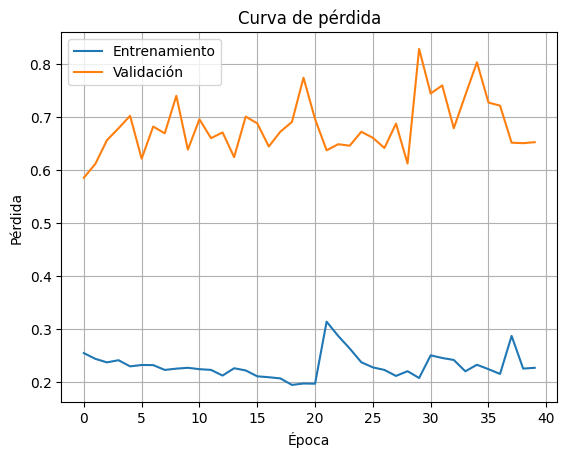

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curva de pérdida')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Split the test_pairs into two separate arrays for each image in the pair
test_pairs_a = test_pairs[:, 0]
test_pairs_b = test_pairs[:, 1]

predictions = model.predict([test_pairs_a, test_pairs_b])
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_labels_cat, axis=1)  # Use test_labels_cat for evaluation

print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

print("Matriz de confusión:")
print(confusion_matrix(y_true, y_pred))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.46      0.54      0.49       300
           1       0.81      0.76      0.79       800

    accuracy                           0.70      1100
   macro avg       0.64      0.65      0.64      1100
weighted avg       0.72      0.70      0.71      1100

Matriz de confusión:
[[162 138]
 [193 607]]


# Guardado del modelo y label

In [ ]:
model.save('/content/drive/MyDrive/dataset_signature/model_signature.h5')

In [ ]:
import pickle

# Guardar el LabelEncoder
with open('/content/drive/MyDrive/dataset_signature/label_signature.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)